# 1. Configuration

In [1]:
import os
import gc
import cv2
import copy
import random
import numpy as np
import pandas as pd
import polars as pl
from pathlib import Path
import typing as tp
from io import BytesIO
from PIL import Image
import h5py
import timm
from time import time
from tqdm.notebook import tqdm
import shutil

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedGroupKFold

import wandb
import torch
import torchvision
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch import amp
from torch.utils.data import Dataset
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

exp = 39
wandb.login()
wandb.init(project="ISIC2024", name=f"experiment_{exp}")



In [2]:
class CFG:
    
    exp = exp
    
    is_kaggle = False
    is_infer = False
    if is_kaggle:
        OUTPUT_DIR = Path('/kaggle/input/isic2024-baseline')
        TRAIN_DIR = Path('/kaggle/input/isic-2024-challenge/train-image/image')
        TRAIN_HDF5 = Path('/kaggle/input/isic-2024-challenge/train-image.hdf5')
        TEST_HDF5 = Path('/kaggle/input/isic-2024-challenge/test-image.hdf5')
        TRAIN_META = Path('/kaggle/input/isic-2024-challenge/train-metadata.csv')
        TEST_META = Path('/kaggle/input/isic-2024-challenge/test-metadata.csv')
        SAMPLE_SUB = Path('/kaggle/input/isic-2024-challenge/sample_submission.csv')
        PRETRAINED_MODEL = ''
        
    else:
        OUTPUT_DIR = Path(f'/root/Development/Kaggle/ISIC2024/main/models/experiments/exp{exp}/outputs')
        OUTPUT_LOG = Path(f'/root/Development/Kaggle/ISIC2024/main/models/experiments/exp{exp}/log.txt')
        TRAIN_DIR = Path('/root/Development/Kaggle/ISIC2024/data/raw/train-image/image')
        TRAIN_HDF5 = Path('/root/Development/Kaggle/ISIC2024/data/raw/train-image.hdf5')
        TEST_HDF5 = Path('/root/Development/Kaggle/ISIC2024/data/raw/test-image.hdf5')
        TRAIN_META = Path('/root/Development/Kaggle/ISIC2024/data/raw/train-metadata.csv')
        TEST_META = Path('/root/Development/Kaggle/ISIC2024/data/raw/test-metadata.csv')
        SAMPLE_SUB = Path('/root/Development/Kaggle/ISIC2024/data/raw/sample_submission.csv')
        TRAIN_META_ADD = Path('/root/Development/Kaggle/ISIC2024/data/external/All/metadata.csv')
        TRAIN_HDF5_ADD = Path('/root/Development/Kaggle/ISIC2024/data/external/All/image.hdf5')
        TRAIN_HDF5_COMBINED = Path('/root/Development/Kaggle/ISIC2024/data/processed/train-image-combined.hdf5')
        PRETRAINED_MODEL = ''
        # PRETRAINED_MODEL = Path('/root/Development/Kaggle/ISIC2024/main/models/experiments/exp32/outputs/averaged_model.pth')
        
    
    es_patience = 5
    batch_size = 64 # 128 # 256
    max_epoch = 8
    n_folds = 2
    n_classes = 2
    random_seed = 42
    lr = 1.0e-04 # lr = 1.0e-03
    weight_decay = 1.0e-02 # default
    deterministic = True
    enable_amp = True
    view = True
    change_dataset = True
    standardization = True
    oversampling = False
    oversampling_percent = 3
    only_lesion_id = False
    alldata_isic_archive = False
    test_of_averaged_model = False
    train_with_fewdata: int|bool = 100000 # or False
    pretrained = True
    TTA: bool = True
    TTA_rate = {'None':0.7, 'with_train_aug':0.3}
    
    model_name = 'maxvit_rmlp_nano_rw_256.sw_in1k'
    output_dim_models = { 
        "resnet18.a1_in1k": 512,
        "efficientnet_b0.ra_in1k": 320,
        "tf_efficientnet_b0.ns_jft_in1k": 1280,
        # 'tf_efficientnet_b5.ns_jft_in1k': 1280,
        'tf_efficientnet_b3.ns_jft_in1k': 1536,
        'eva02_large_patch14_224.mim_in22k': 384,
        'eva02_large_patch14_448.mim_m38m_ft_in22k_in1k': 384,
        'maxvit_tiny_tf_224.in1k': 256,
        'maxvit_rmlp_nano_rw_256.sw_in1k': 256,
        'maxvit_rmlp_pico_rw_256.sw_in1k': 256,
        'maxvit_small_tf_224.in1k': 256,
    }
    
    # img_size = 224
    img_size = 256
    # img_size = 384
    interpolation = cv2.INTER_LINEAR
    
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"

In [3]:

train_meta = pd.read_csv(CFG.TRAIN_META)
test_meta = pd.read_csv(CFG.TEST_META)
print(len(train_meta))
print(len(test_meta))

# head
display(train_meta[train_meta['target'] > 0.5].head(10))
display(train_meta.head())
display(test_meta.head())


if not CFG.is_infer:
    train_meta_add = pd.read_csv(CFG.TRAIN_META_ADD)
    print(len(train_meta_add))
    display(train_meta_add.head())

401059
3


/tmp/ipykernel_1699666/3686719533.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_meta = pd.read_csv(CFG.TRAIN_META)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
387,ISIC_0082829,1,IP_3249371,80.0,female,anterior torso,9.27,TBP tile: close-up,3D: XP,18.093368,13.054772,19.090458,21.211776,26.302386,24.907158,46.536028,58.389811,23.395088,34.784341,40.964534,25.940259,3.287692,5.038595,-2.121318,-11.389253,11.836020,12.342322,0.763841,Torso Front Top Half,Torso Front,6.677133,1.597228e-02,5.936484,9.830578,32.598015,3.514434,5.464301,2.717044,0.472358,0,61.956005,1180.003540,-77.904053,"Department of Dermatology, Hospital Clínic de ...",CC-BY-NC,IL_7881385,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,Squamous cell carcinoma in situ,NaN,NaN,NaN,NaN,72.211683
935,ISIC_0096034,1,IP_6723298,75.0,male,head/neck,3.88,TBP tile: close-up,3D: white,26.187010,21.394010,25.553420,24.914770,36.588750,32.839750,44.298420,49.347720,49.373060,57.114240,6.192531,30.648580,0.624458,4.793001,0.638651,-7.741185,8.023705,5.716512,0.672715,Head & Neck,Head & Neck,2.710643,9.713997e-04,7.567831,1.757932,13.776510,0.549971,1.604156,2.798056,0.576744,15,54.423520,1675.860000,-37.749880,Memorial Sloan Kettering Cancer Center,CC-BY,IL_5240575,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,94.559590
1245,ISIC_0104229,1,IP_9057861,80.0,male,anterior torso,6.55,TBP tile: close-up,3D: white,33.480140,24.249430,26.160100,25.295430,42.488470,35.041320,38.002700,46.209460,50.728930,58.546240,12.103580,38.025960,1.401430,9.230707,0.864665,-7.817310,8.023790,5.621653,0.907116,Torso Front Top Half,Torso Front,3.481341,1.629116e-12,8.688260,4.108186,21.453450,1.340916,1.539307,3.697858,0.546485,155,84.834820,1441.758000,-60.321040,Memorial Sloan Kettering Cancer Center,CC-BY,IL_1702337,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,NaN,NaN,66.196170
1846,ISIC_0119495,1,IP_6856511,60.0,male,upper extremity,5.27,TBP tile: close-up,3D: white,25.872050,20.194650,26.805590,28.459890,37.254570,34.896840,46.015270,54.641140,56.674930,64.638890,13.267030,30.444160,1.472167,5.677403,-1.654301,-7.963960,8.284219,5.481429,0.745061,Right Arm - Upper,Right Arm,3.573096,1.106073e+00,6.435350,3.850777,20.097350,1.104453,2.575811,2.600541,0.428889,160,293.127500,1425.201000,50.789730,Memorial Sloan Kettering Cancer Center,CC-BY,IL_3266850,Malignant::Malignant epidermal proliferations:...,Malignant,Malignant epidermal proliferations,"Squamous cell carcinoma, Invasive",NaN,NaN,NaN,NaN,99.991270
3478,ISIC_0157834,1,IP_3927284,55.0,male,posterior torso,5.29,TBP tile: close-up,3D: white,30.966662,22.008635,24.066940,26.734379,39.219278,34.628125,37.853948,50.537646,55.210012,66.135030,15.049728,24.313243,2.243673,8.958027,-2.667440,-10.925018,11.522597,7.399501,0.690814,Torso Back Top Third,Torso Back,4.222128,2.115099e-02,5.267599,7.734870,19.128714,2.904396,4.122797,3.134399,0.422091,65,-128.599152,1481.198364,13.294312,Memorial Sloan Kettering Cancer Center,CC-BY,IL_2429082,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Bas

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,55.828924,54.367448,62.025701,3.152561,27.476170,0.00000,3.982447,2.967674,-7.658253,8.360566,5.784302,0.901302,Right Leg - Upper,Right Leg,1.543016,2.628592e-03,7.091360,0.000000,9.307003,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,44.064040,48.861520,55.362360,0.919497,12.235290,0.00000,6.347830,1.781713,-6.500838,6.839008,4.987244,0.639885,Head & Neck,Head & Neck,0.821918,1.334303e-07,2.116402,0.000000,3.354148,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,Memorial Sloan Kettering Cancer Center,CC-BY,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,17.128170,37.970460,33.485410,44.174920,37.611800,59.265850,62.909730,53.961180,61.670520,3.265153,24.184620,0.00000,5.447655,4.485044,-7.709336,9.092376,6.290359,0.932147,Torso Back Top Third,Torso Back,1.194905,2.959177e-04,4.798335,0.000000,8.886309,0.00000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,12.164757,21.448144,21.121356,25.746200,24.374023,56.414429,60.060388,18.649518,23.314841,6.079940,14.889242,0.51452,2.077572,0.326788,-4.665323,4.783413,6.400196,0.654458,Torso Front Top Half,Torso Front,2.481328,2.198945e+01,1.975874,1.771705,9.514499,0.66469,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802,ACEMID MIA,CC-0,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,20.057470,26.464900,25.710460,36.217980,32.608740,46.946070,52.041180,46.276310,54.855740,2.101708,19.902560,0.00000,4.668053,0.754434,-8.579431,9.148495,6.531302,0.946448,Torso Front Top Half,Torso Front,0.929916,1.378832e-03,3.658854,0.000000,6.467562,0.00000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,28.38412,27.043640,36.410100,33.640000,51.220960,53.505430,24.97985,31.114600,3.846876,22.907010,0.461149,2.797056,1.340481,-6.134747,6.436557,6.843057,0.664465,Torso Back Top Third,Torso Back,2.187644,1.698104e-02,5.435366,1.143374,9.387248,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,31.31752,27.524318,35.467806,29.169579,62.004494,70.664619,59.90409,68.141071,2.120473,18.957821,0.000000,6.990705,3.793202,-8.236981,9.151127,6.083388,0.926698,Left Leg - Upper,Left Leg,1.032666,2.107364e-01,4.322201,0.000000,6.340311,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,30.46368,28.384240,38.939500,34.686660,51.474730,54.915410,35.81945,41.358640,3.396510,19.464400,0.251236,4.316465,2.079433,-5.539191,6.041092,5.446997,0.894776,Torso Back Top Third,Torso Back,1.520786,8.052259e-13,3.968912,0.721739,8.130868,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


81722


/tmp/ipykernel_1699666/3686719533.py:13: DtypeWarning: Columns (8,13,16,17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  train_meta_add = pd.read_csv(CFG.TRAIN_META_ADD)


,isic_id,attribution,copyright_license,acquisition_day,age_approx,anatom_site_general,benign_malignant,clin_size_long_diam_mm,concomitant_biopsy,dermoscopic_type,diagnosis,diagnosis_confirm_type,family_hx_mm,fitzpatrick_skin_type,image_type,lesion_id,mel_class,mel_mitotic_index,mel_thick_mm,mel_type,mel_ulcer,melanocytic,nevus_type,patient_id,personal_hx_mm,pixels_x,pixels_y,sex
0,ISIC_7559201,Memorial Sloan Kettering Cancer Center,CC-BY,2497.0,55.0,anterior torso,benign,6.6,NaN,contact non-polarized,nevus,histopathology,True,IV,dermoscopic,IL_2668505,NaN,NaN,NaN,NaN,NaN,True,NaN,IP_1238256,True,3264,2448,female
1,ISIC_0485014,Memorial Sloan Kettering Cancer Center,CC-BY,1.0,45.0,lower extremity,benign,NaN,NaN,contact non-polarized,NaN,NaN,True,I,dermoscopic,IL_2775050,NaN,NaN,NaN,NaN,NaN,True,NaN,IP_3227071,NaN,6000,4000,female
2,ISIC_5257439,Memorial Sloan Kettering Cancer Center,CC-BY,2360.0,40.0,lateral torso,benign,4.2,NaN,NaN,nevus,histopathology,True,II,clinical: close-up,IL_8547824,NaN,NaN,NaN,NaN,NaN,True,NaN,IP_7407753,True,3264,2448,female
3,ISIC_2989732,Memorial Sloan Kettering Cancer Center,CC-BY,78.0,80.0,anterior torso,benign,NaN,NaN,non-contact polarized,NaN,NaN,False,II,dermoscopic,IL_4657752,NaN,NaN,NaN,NaN,NaN,True,NaN,IP_2597637,NaN,6000,4000,male
4,ISIC_5638210,Memorial Sloan Kettering Cancer Center,CC-BY,78.0,80.0,anterior torso,benign,NaN,NaN,contact non-polarized,NaN,NaN,False,II,dermoscopic,IL_4657752,NaN,NaN,NaN,NaN,NaN,True,NaN,IP_2597637,NaN,6000,4000,male


# 2. Preprocessing

### process additional data

In [4]:
if not CFG.is_infer:

    # only benign or maligant
    train_meta_add = train_meta_add[train_meta_add['benign_malignant'].isin(['benign', 'malignant'])]
    # make the target column
    train_meta_add['target'] = train_meta_add['benign_malignant'].apply(lambda x: 1 if x == 'malignant' else 0)
    # assign difference patientid
    train_meta_add['patient_id'] = [
        f"example_{i+1}" if pd.isna(id) else id
        for i, id in enumerate(train_meta_add['patient_id'])
    ]

    train_meta_add['additional'] = 1

    display(train_meta_add.head())


,isic_id,attribution,copyright_license,acquisition_day,age_approx,anatom_site_general,benign_malignant,clin_size_long_diam_mm,concomitant_biopsy,dermoscopic_type,diagnosis,diagnosis_confirm_type,family_hx_mm,fitzpatrick_skin_type,image_type,lesion_id,mel_class,mel_mitotic_index,mel_thick_mm,mel_type,mel_ulcer,melanocytic,nevus_type,patient_id,personal_hx_mm,pixels_x,pixels_y,sex,target,additional
0,ISIC_7559201,Memorial Sloan Kettering Cancer Center,CC-BY,2497.0,55.0,anterior torso,benign,6.6,NaN,contact non-polarized,nevus,histopathology,True,IV,dermoscopic,IL_2668505,NaN,NaN,NaN,NaN,NaN,True,NaN,IP_1238256,True,3264,2448,female,0,1
1,ISIC_0485014,Memorial Sloan Kettering Cancer Center,CC-BY,1.0,45.0,lower extremity,benign,NaN,NaN,contact non-polarized,NaN,NaN,True,I,dermoscopic,IL_2775050,NaN,NaN,NaN,NaN,NaN,True,NaN,IP_3227071,NaN,6000,4000,female,0,1
2,ISIC_5257439,Memorial Sloan Kettering Cancer Center,CC-BY,2360.0,40.0,lateral torso,benign,4.2,NaN,NaN,nevus,histopathology,True,II,clinical: close-up,IL_8547824,NaN,NaN,NaN,NaN,NaN,True,NaN,IP_7407753,True,3264,2448,female,0,1
3,ISIC_2989732,Memorial Sloan Kettering Cancer Center,CC-BY,78.0,80.0,anterior torso,benign,NaN,NaN,non-contact polarized,NaN,NaN,False,II,dermoscopic,IL_4657752,NaN,NaN,NaN,NaN,NaN,True,NaN,IP_2597637,NaN,6000,4000,male,0,1
4,ISIC_5638210,Memorial Sloan Kettering Cancer Center,CC-BY,78.0,80.0,anterior torso,benign,NaN,NaN,contact non-polarized,NaN,NaN,False,II,dermoscopic,IL_4657752,NaN,NaN,NaN,NaN,NaN,True,NaN,IP_2597637,NaN,6000,4000,male,0,1


### process original data

In [5]:
if not CFG.is_infer:

    # delete clothes and others
    # List of IDs to drop
    ids_to_drop = ['ISIC_0573025', 'ISIC_1443812', 'ISIC_5374420', 'ISIC_2611119', 'ISIC_2691718', 'ISIC_9689783', 'ISIC_9520696', 'ISIC_8651165', 'ISIC_9385142', 'ISIC_9680590']
    train_meta = train_meta.drop(train_meta[train_meta['isic_id'].isin(ids_to_drop)].index)
    train_meta = train_meta.reset_index(drop=True)

    if CFG.train_with_fewdata:
        filtered_train_meta = train_meta[train_meta['lesion_id'].notnull()]
        print("len filtered_train_meta: ", len(filtered_train_meta))

        # Select 100 rows from the remaining DataFrame
        remaining_rows = train_meta[~train_meta.index.isin(filtered_train_meta.index)]
        selected_rows = remaining_rows.sample(n=CFG.train_with_fewdata - len(filtered_train_meta), random_state=CFG.random_seed).reset_index(drop=True)

        # Combine both DataFrames
        combined_df = pd.concat([filtered_train_meta, selected_rows]).reset_index(drop=True)
        train_meta = combined_df

    # only has lesion_id(strgong label)
    if CFG.only_lesion_id:
        train_meta = train_meta[train_meta['lesion_id'].notnull()].reset_index(drop=True)
        
        
        
    # add "additional" column
    train_meta['additional'] = 0

    print(len(train_meta))
    print(len(train_meta[train_meta['target']==1]))
    print(len(train_meta[train_meta['target']==1]) / len(train_meta) * 100, '%')
    display(train_meta.head())

len filtered_train_meta:  22053
100000
393
0.393 %


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,additional
0,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,44.064040,48.861520,55.362360,0.919497,12.235290,0.000000,6.347830,1.781713,-6.500838,6.839008,4.987244,0.639885,Head & Neck,Head & Neck,0.821918,1.334303e-07,2.116402,0.000000,3.354148,0.000000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,Memorial Sloan Kettering Cancer Center,CC-BY,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,0
1,ISIC_0073301,0,IP_2536274,40.0,female,posterior torso,9.59,TBP tile: close-up,3D: XP,24.237019,14.291773,28.042227,26.965422,37.064802,30.518663,49.163002,62.076246,46.763747,72.098259,31.975980,22.662001,3.947276,9.945246,1.076805,-25.334512,25.594803,15.996656,0.900678,Torso Back Middle Third,Torso Back,4.925942,9.964820e+01,2.910906,9.913684,26.919133,3.215515,11.156617,2.108142,0.144565,105,179.450317,1042.495850,180.077301,"Frazer Institute, The University of Queensland...",CC-BY,IL_3854228,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.886191,0
2,ISIC_0073989,0,IP_1307115,50.0,male,upper extremity,6.39,TBP tile: close-up,3D: white,19.600317,16.808140,29.830666,31.199751,35.693711,35.439216,56.692980,61.687465,56.975435,68.329111,28.617001,18.052941,1.522630,2.792177,-1.369085,-11.353676,11.614445,7.462467,0.338695,Left Arm - Upper,Left Arm,5.977840,2.394399e+01,2.187051,4.998895,22.729299,1.807261,2.590515,2.508804,0.160248,10,-405.034302,1314.600342,65.054626,Memorial Sloan Kettering Cancer Center,CC-BY,IL_9898853,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.997449,0
3,ISIC_0074611,0,IP_6164902,40.0,female,lower extremity,3.31,TBP tile: close-up,3D: XP,18.007100,10.746140,24.833930,22.160240,30.675390,24.628360,54.054120,64.129910,35.715100,49.169140,5.948583,14.665700,1.255051,7.260954,2.673692,-13.454040,13.913190,11.708370,0.771271,Right Leg - Upper,Right Leg,2.127617,9.946209e+01,1.791452,3.382435,9.340242,1.006729,4.879771,1.308662,0.190184,140,74.994020,619.913700,9.337646,"Frazer Institute, The University of Queensland...",CC-BY,IL_2988728,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,0
4,ISIC_0075969,0,IP_5117525,40.0,female,posterior torso,9.05,TBP tile: close-up,3D: XP,21.315824,9.534200,30.914309,28.973342,37.550751,30.501730,55.413224,71.785279,46.968562,61.598336,46.162507,16.830977,3.170209,11.781624,1.940967,-14.629774,14.990645,10.669963,0.641768,Torso Back Middle Third,Torso Back,6.848261,9.902058e+01,1.645372,9.528097,27.874004,3.187016,4.978959,2.676386,0.117188,175,10.673340,1024.758179,154.668274,ACEMID MIA,CC-0,IL_6219432,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999905,0


### concat both data

In [6]:
if not CFG.is_infer:

    concatenated = pd.concat([train_meta, train_meta_add], axis=0)
    if CFG.alldata_isic_archive:
        train_meta = concatenated.reset_index(drop=True)
        display(train_meta.head())
        display(train_meta.tail())

# 3. Split to fold

In [7]:
if not CFG.is_infer:


    def split_fold(df:pd.DataFrame):
        # if 'fold' in df.columns:
        #     return df
        
        df['fold'] = -1
        # object
        skf = StratifiedGroupKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.random_seed)

        for i, (train_index, test_index) in enumerate(skf.split(df, df['target'], df['patient_id'])):
            df.loc[test_index, 'fold'] = i
        
        return df
            
    train_meta = split_fold(train_meta)
    display(train_meta.head().T)

    # check
    if CFG.view:
        print(train_meta.groupby('fold')['target'].value_counts().head(300))

,0,1,2,3,4
isic_id,ISIC_0015845,ISIC_0073301,ISIC_0073989,ISIC_0074611,ISIC_0075969
target,0,0,0,0,0
patient_id,IP_8170065,IP_2536274,IP_1307115,IP_6164902,IP_5117525
age_approx,60.0,40.0,50.0,40.0,40.0
sex,male,female,male,female,female
anatom_site_general,head/neck,posterior torso,upper extremity,lower extremity,posterior torso
clin_size_long_diam_mm,1.1,9.59,6.39,3.31,9.05
image_type,TBP tile: close-up,TBP tile: close-up,TBP tile: close-up,TBP tile: close-up,TBP tile: close-up
tbp_tile_type,3D: white,3D: XP,3D: white,3D: XP,3D: XP
tbp_lv_A,31.71257,24.237019,19.600317,18.0071,21.315824


fold  target
0     0         47449
      1           200
1     0         52158
      1           193
Name: count, dtype: int64


### OverSampling

In [8]:
if not CFG.is_infer:
    if CFG.oversampling:

        percent = CFG.oversampling_percent

        train_meta_mali = train_meta[train_meta['target']==1]
        for _ in range(100):
            train_meta = pd.concat([train_meta, train_meta_mali], axis=0)
            if len(train_meta[train_meta['target']==1]) / len(train_meta) * 100 >= percent:
                print(f'over {percent}% malignant')
                break

        print(len(train_meta))
        print(len(train_meta[train_meta['target']==1]))
        print(len(train_meta[train_meta['target']==1]) / len(train_meta) * 100, '%')

        del percent

        if CFG.view:
            print(train_meta.groupby('fold')['target'].value_counts().head(300))
            display(train_meta.head())

# 4. Dataset

In [9]:
# setting seed in each env
def set_random_seed(seed: int = 42, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = deterministic  # type: ignore

# function to set tensor to device
def to_device(
    tensors: tp.Union[tp.Tuple[torch.Tensor], tp.Dict[str, torch.Tensor]],
    device: torch.device, *args, **kwargs
):
    if isinstance(tensors, tuple):
        return (t.to(device, *args, **kwargs) for t in tensors)
    elif isinstance(tensors, dict):
        return {
            k: t.to(device, *args, **kwargs) for k, t in tensors.items()}
    else:
        return tensors.to(device, *args, **kwargs)

In [10]:

def get_transforms(include_light=False):
    augmentations_train = A.Compose([
    A.Transpose(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, p=0.3),
    A.OneOf([
            A.MotionBlur(blur_limit=5, p=0.5),
            A.MedianBlur(blur_limit=5, p=0.5),
            A.GaussianBlur(blur_limit=5, p=0.5),
        ], p=0.2),
    A.GaussNoise(var_limit=(5.0, 30.0), p=0.1),
    # A.OpticalDistortion(distort_limit=0.5, p=0.3),
    # A.GridDistortion(num_steps=5, distort_limit=0.5, p=0.3),
    # A.ElasticTransform(alpha=1, p=0.3),
    # A.CLAHE(clip_limit=2.0, p=0.3),
    # A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=5, p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.3),
    A.CoarseDropout(max_holes=20, min_holes=10, p=0.3),
    A.Resize(CFG.img_size, CFG.img_size),
    # A.Normalize(
    #                 mean=[0.485, 0.456, 0.406], 
    #                 std=[0.229, 0.224, 0.225], 
    #                 max_pixel_value=255.0, 
    #                 p=1.0
    #             ),
    ToTensorV2(p=1)
    ])
    augmentations_train_light = A.Compose([
        A.Transpose(p=0.5),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, p=0.1),
        A.OneOf([
            A.MotionBlur(blur_limit=5, p=0.5),
            A.MedianBlur(blur_limit=5, p=0.5),
            A.GaussianBlur(blur_limit=5, p=0.5),
        ], p=0.1),
        # A.GaussNoise(var_limit=(5.0, 30.0), p=0.5),
        # A.OpticalDistortion(distort_limit=0.5, p=0.5),
        # A.GridDistortion(num_steps=5, distort_limit=0.5, p=0.5),
        # A.ElasticTransform(alpha=1, p=0.5),
        # A.CLAHE(clip_limit=2.0, p=0.5),
        # A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=5, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.2),
        A.CoarseDropout(max_holes=30, min_holes=20, p=0.2),
        A.Resize(CFG.img_size, CFG.img_size),
        # A.Normalize(
        #                 mean=[0.485, 0.456, 0.406], 
        #                 std=[0.229, 0.224, 0.225], 
        #                 max_pixel_value=255.0, 
        #                 p=1.0
        #             ),
        ToTensorV2(p=1)
    ])
    
    augmentations_test = A.Compose([
        A.Resize(CFG.img_size, CFG.img_size),
        # A.Normalize(
        #                 mean=[0.485, 0.456, 0.406], 
        #                 std=[0.229, 0.224, 0.225], 
        #                 max_pixel_value=255.0, 
        #                 p=1.0
        #             ),
        ToTensorV2(p=1)
    ])
    if include_light:
        return augmentations_train, augmentations_test, augmentations_train_light
    return augmentations_train, augmentations_test

# def get_transforms():
#     data_transforms = {
#         "train": A.Compose([
#             A.Resize(CFG.img_size, CFG.img_size),
#             A.RandomRotate90(p=0.5),
#             A.Flip(p=0.5),
#             A.Downscale(p=0.25),
#             A.ShiftScaleRotate(shift_limit=0.1, 
#                             scale_limit=0.15, 
#                             rotate_limit=60, 
#                             p=0.5),
#             A.HueSaturationValue(
#                     hue_shift_limit=0.2, 
#                     sat_shift_limit=0.2, 
#                     val_shift_limit=0.2, 
#                     p=0.5
#                 ),
#             A.RandomBrightnessContrast(
#                     brightness_limit=(-0.1,0.1), 
#                     contrast_limit=(-0.1, 0.1), 
#                     p=0.5
#                 ),
#             A.Normalize(
#                     mean=[0.485, 0.456, 0.406], 
#                     std=[0.229, 0.224, 0.225], 
#                     max_pixel_value=255.0, 
#                     p=1.0
#                 ),
#             ToTensorV2()], p=1.),
        
#         "valid": A.Compose([
#             A.Resize(CFG.img_size, CFG.img_size),
#             A.Normalize(
#                     mean=[0.485, 0.456, 0.406], 
#                     std=[0.229, 0.224, 0.225], 
#                     max_pixel_value=255.0, 
#                     p=1.0
#                 ),
#             ToTensorV2()], p=1.)
#     }
#     return data_transforms["train"], data_transforms["valid"]

# def get_transforms():
#     train_transforms = A.Compose([
#         A.Transpose(p=0.5),
#         A.VerticalFlip(p=0.5),
#         A.HorizontalFlip(p=0.5),
#         A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.75),
#         A.OneOf([
#             A.MotionBlur(blur_limit=5),
#             A.MedianBlur(blur_limit=5),
#             A.GaussianBlur(blur_limit=5),
#             A.GaussNoise(var_limit=(5.0, 30.0)),
#         ], p=0.7),

#         A.OneOf([
#             A.OpticalDistortion(distort_limit=1.0),
#             A.GridDistortion(num_steps=5, distort_limit=1.),
#             A.ElasticTransform(alpha=3),
#         ], p=0.7),

#         A.CLAHE(clip_limit=4.0, p=0.7),
#         A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
#         A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
#         A.Resize(CFG.img_size, CFG.img_size),
#         A.CoarseDropout(max_height=int(CFG.img_size * 0.375), max_width=int(CFG.img_size * 0.375), max_holes=1, min_holes=1, p=0.7),    
#         A.Normalize()
#     ])

#     val_transforms = A.Compose([
#         A.Resize(CFG.img_size, CFG.img_size),
#         A.Normalize()
#     ])

#     return train_transforms, val_transforms


In [11]:

class ISICDataset(Dataset):
    def __init__(self, 
                df: pd.DataFrame,
                fp_hdf: str|Path,
                transform: A.Compose=None,
                ):
        self.df = df
        if 'target' in self.df.columns:
            self.is_training = True
            self.targets = df['target'].values
        else:
            self.is_training = False
        self.fp_hdf = h5py.File(fp_hdf, mode="r")
        self.isic_ids = df['isic_id'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.isic_ids)
    
    def __getitem__(self, index):
        isic_id = self.isic_ids[index]
        image = np.array(Image.open(BytesIO(self.fp_hdf[isic_id][()])))
        if self.is_training:
            target = self.targets[index]
        else:
            target = []
        
        if self.transform:
            return (self._apply_transform(image), target)
        else:
            return (image, target)
    
    def _apply_transform(self, img:np.ndarray):
        """apply transform to image"""
        transformed = self.transform(image=img)
        img = transformed["image"]# .float()# .half()
        return img

# 5. Model

In [12]:

def F_rgb2hsv(rgb: torch.Tensor) -> torch.Tensor:
    cmax, cmax_idx = torch.max(rgb, dim=1, keepdim=True)
    cmin = torch.min(rgb, dim=1, keepdim=True)[0]
    delta = cmax - cmin
    hsv_h = torch.empty_like(rgb[:, 0:1, :, :])
    cmax_idx[delta == 0] = 3
    hsv_h[cmax_idx == 0] = (((rgb[:, 1:2] - rgb[:, 2:3]) / delta) % 6)[cmax_idx == 0]
    hsv_h[cmax_idx == 1] = (((rgb[:, 2:3] - rgb[:, 0:1]) / delta) + 2)[cmax_idx == 1]
    hsv_h[cmax_idx == 2] = (((rgb[:, 0:1] - rgb[:, 1:2]) / delta) + 4)[cmax_idx == 2]
    hsv_h[cmax_idx == 3] = 0.
    hsv_h /= 6.
    hsv_s = torch.where(cmax == 0, torch.tensor(0.).type_as(rgb), delta / cmax)
    hsv_v = cmax
    return torch.cat([hsv_h, hsv_s, hsv_v], dim=1)

# linear can treat any input size
class DynamicLinear(nn.Module):
    def __init__(self, out_size):
        super(DynamicLinear, self).__init__()
        self.out_size = out_size
        self.linear = None

    def forward(self, x):
        if self.linear is None:
            in_features = x.size(-1)
            self.linear = nn.Linear(in_features, self.out_size).to(x.device)
        
        return self.linear(x)


class timmModel(nn.Module):

    def __init__(
            self,
            model_name: str,
            pretrained: bool,
            in_channels: int,
            num_classes: int,
            is_training: bool=False
        ):
        super().__init__()
        if 'eva' in CFG.model_name:
            self.model = timm.create_model(
                model_name=model_name, 
                pretrained=pretrained, 
                in_chans=in_channels,
                num_classes=num_classes,
                # global_pool=''
            )
        else:
            self.model = timm.create_model(
                model_name=model_name, 
                pretrained=pretrained, 
                in_chans=in_channels,
                num_classes=num_classes,
                global_pool=''
            )
        
        self.output_type = ['infer', 'loss']
        self.is_training = is_training

        # model output dim
        dim = CFG.output_dim_models[CFG.model_name]
        
        self.dropout = nn.ModuleList([
            nn.Dropout(0.5) for i in range(5)
        ])
        # self.target=nn.Linear(dim, 1)
        self.target=DynamicLinear(out_size=1)
        # self.target_aux=nn.Linear(dim, 1)
        

    def forward(self, x, target=None):
        batch_size = len(x)
        
        x = torch.cat([x, F_rgb2hsv(x)],1) # (bs, dim, h, w)
        x = self.model(x)    
        # print('model output: ', x.shape)
        
        if not 'eva' in CFG.model_name:
            pool = F.adaptive_avg_pool2d(x, 1)
            # print('after pooling: ', pool.shape)
            reshaped = pool.reshape(batch_size, -1)  
            # print('after reshape: ', reshaped.shape)
        
        else:
            reshaped = x
        
        if self.is_training:
            logit = 0
            # print(len(self.dropout))
            for i in range(len(self.dropout)):
                dropped = self.dropout[i](reshaped)
                # print(dropped.shape)
                logit += self.target(dropped)
            logit = logit / len(self.dropout)
        else:
            logit = self.target(reshaped)
            
        output = {}
        if 'loss' in self.output_type:
            if target.dim() == 1:
                target = target.view(-1, 1)
            output['bce_loss'] = F.binary_cross_entropy_with_logits(logit.float(), target.float())

        if 'infer' in self.output_type:
            output['target'] = torch.sigmoid(logit.float())

        return output
    
    def initialize_dummy(self):
        # Initialize the DynamicLinear layer with dummy input data
        original_output_type = self.output_type
        self.output_type = ['infer']
        
        dummy_input = torch.zeros(1, 3, CFG.img_size, CFG.img_size)  # Assuming input size (1, 3, 224, 224)
        _ = self.forward(dummy_input)
        
        self.output_type = original_output_type

/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/blur/transforms.py:180: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


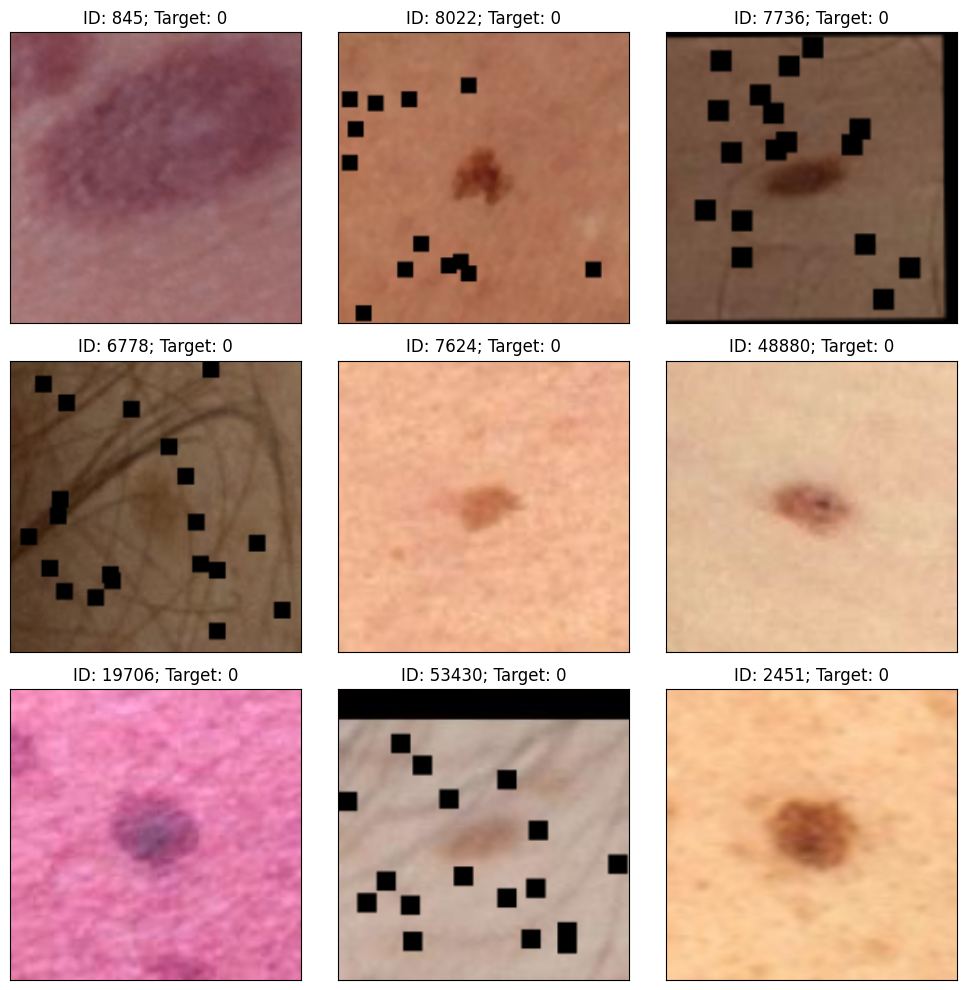

In [13]:
if not CFG.is_infer:


    if CFG.view:
        def show_batch(ds, row=3, col=3, color='rgb'):
            fig = plt.figure(figsize=(10, 10))
            img_index = np.random.randint(0, len(ds)-1, row*col)
            
            for i in range(len(img_index)):
                img, label = ds[img_index[i]]
                img_rgb = img[:3, :, :]
                # img_hsv = img[3:6, :, :]
                
                if color=='rgb':
                    img = img_rgb
                # elif color=='hsv':
                #     img = img_hsv
                
                if isinstance(img, torch.Tensor):
                    img = img.detach().numpy()
                    # Check if the image is in (C, H, W) and transpose it to (H, W, C)
                    if img.shape[0] == 3:  # Assuming the image is (C, H, W)
                        img = np.transpose(img, (1, 2, 0))
                
                ax = fig.add_subplot(row, col, i + 1, xticks=[], yticks=[])
                ax.imshow(img)  # Remove cmap parameter for RGB images
                ax.set_title(f'ID: {img_index[i]}; Target: {label}')
            
            plt.tight_layout()
            plt.show()

        _train_transform, _ = get_transforms()
        if CFG.alldata_isic_archive:
            _dataset = ISICDataset(df=train_meta, fp_hdf=CFG.TRAIN_HDF5_COMBINED, transform=_train_transform)
        else:
            _dataset = ISICDataset(df=train_meta, fp_hdf=CFG.TRAIN_HDF5, transform=_train_transform)
        show_batch(_dataset)
        # show_batch(_dataset, color='hsv')


# 6. Training

In [14]:
if not CFG.is_infer:


    # reference
    def train_one_fold(val_fold: int, 
                    train: pd.DataFrame,
                    output_path: str|Path
                    ):
        """Main"""
        # If True, forces cuDNN to benchmark multiple convolution algorithms and choose the fastest one
        torch.backends.cudnn.benchmark = True
        set_random_seed(CFG.random_seed, deterministic=CFG.deterministic)
        # set device with pytorch env
        device = torch.device(CFG.device)
        # print(device)
        
        train_transform, val_transform = get_transforms()
        
    #     train_dataset = Bird2024Dataset(**train_path_label, transform=train_transform)
        if CFG.alldata_isic_archive:
            train_dataset = ISICDataset(train[train['fold']!=val_fold], CFG.TRAIN_HDF5_COMBINED, train_transform)
            train_dataset_noaugment = ISICDataset(train[train['fold']!=val_fold], CFG.TRAIN_HDF5_COMBINED, val_transform)
            val_dataset = ISICDataset(train[train['fold']==val_fold], CFG.TRAIN_HDF5_COMBINED, val_transform)
        else:
            train_dataset = ISICDataset(train[train['fold']!=val_fold], CFG.TRAIN_HDF5, train_transform)
            train_dataset_noaugment = ISICDataset(train[train['fold']!=val_fold], CFG.TRAIN_HDF5, val_transform)
            val_dataset = ISICDataset(train[train['fold']==val_fold], CFG.TRAIN_HDF5, val_transform)
        
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=CFG.batch_size, num_workers=4, shuffle=True, drop_last=True)
        train_loader_noaugment = torch.utils.data.DataLoader(
            train_dataset_noaugment, batch_size=CFG.batch_size, num_workers=4, shuffle=True, drop_last=True)
        
        val_loader = torch.utils.data.DataLoader(
            val_dataset, batch_size=CFG.batch_size, num_workers=4, shuffle=False, drop_last=False)
        
        model = timmModel(
            model_name=CFG.model_name, 
            pretrained=CFG.pretrained, 
            num_classes=0, # no classification head
            in_channels=6, # RBG+HSV
            is_training=True
        )
        # transfer learning
        if CFG.PRETRAINED_MODEL:
            model.initialize_dummy()
            model.load_state_dict(torch.load(CFG.PRETRAINED_MODEL, map_location=device))
            
        model = model.to(device)

        
        optimizer = optim.AdamW(params=model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
        scheduler = lr_scheduler.OneCycleLR(
            optimizer=optimizer, epochs=CFG.max_epoch,
            pct_start=0.0, steps_per_epoch=len(train_loader),
            max_lr=CFG.lr, div_factor=25, final_div_factor=1e4
        )
        
    #     loss_func = KLDivLossWithLogits()
        # loss_func = nn.CrossEntropyLoss()
        # loss_func = nn.BCEWithLogitsLoss()
    #     loss_func = FocalLossBCE()
        # loss_func.to(device)
    #     loss_func_val = KLDivLossWithLogitsForVal()
    #     loss_func_val = nn.CrossEntropyLoss()
        # loss_func_val = nn.BCEWithLogitsLoss()
    #     loss_func_val = FocalLossBCE()
        
        use_amp = CFG.enable_amp
        scaler = amp.GradScaler('cuda', enabled=use_amp)
        # scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
        
        best_val_loss = 1.0e+09
        best_epoch = 0
        train_loss = 0
        val_loss = 0
        cumulative_elapsed_time = 0
        
        for epoch in range(1, CFG.max_epoch + 1):
            if CFG.change_dataset & epoch >= ((CFG.max_epoch+1) * 0.6):
                train_loader = train_loader_noaugment
            epoch_start = time()
            model.train()
            for batch in tqdm(train_loader):
                
                x, t = batch
                if CFG.standardization:
                    x = (x - x.min()) / (x.max() - x.min() +1e-6) * 255
                else:
                    x = x.float()/255
                # t = t.float()
    #             print(x)
    #             print(t)
                x = to_device(x, device)
                t = to_device(t, device)
                    
                optimizer.zero_grad()
                # with torch.cuda.amp.autocast(use_amp):
                with amp.autocast('cuda', enabled=use_amp):
                    output = model(x, t)
                    loss = output['bce_loss']
                
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                train_loss += loss.item()
                scheduler.step()
                
            train_loss /= len(train_loader)
                
            model.eval()
            for batch in tqdm(val_loader):
                x, t = batch
                if CFG.standardization:
                    x = (x - x.min()) / (x.max() - x.min() +1e-6) * 255
                else:
                    x = x.float()/255
                x = to_device(x, device)
                t = to_device(t, device)
                # with torch.no_grad(), torch.cuda.amp.autocast(use_amp):
                with torch.no_grad(), amp.autocast('cuda', enabled=use_amp):
                    output = model(x, t)
                loss = output['bce_loss']
                val_loss += loss.item()
            val_loss /= len(val_loader)
            
            if val_loss < best_val_loss:
                best_epoch = epoch
                best_val_loss = val_loss
                # print("save model")
                torch.save(model.state_dict(), str(output_path / f'snapshot_epoch_{epoch}.pth'))
            
            elapsed_time = time() - epoch_start
            cumulative_elapsed_time += elapsed_time
            with open(str(output_path / f'train_log.txt'), 'a') as f:
                f.write('\n')
                f.write(f'exp: {CFG.exp}, [epoch {epoch}] train loss: {train_loss: .6f}, val loss: {val_loss: .6f}, elapsed_time: {elapsed_time: .3f}')
            
            # log
            wandb.log({"Train Loss": train_loss,  "Val Loss": val_loss, "Cumulative Time(m)": cumulative_elapsed_time/60})
            print(
                f"[epoch {epoch}] train loss: {train_loss: .6f}, val loss: {val_loss: .6f}, cumulative_elapsed_time: {cumulative_elapsed_time/60: .1f}m , elapsed_time: {elapsed_time/60: .3f}m")
            
            
            
            if epoch - best_epoch > CFG.es_patience:
                with open(str(output_path / f'train_log.txt'), 'a') as f:
                    f.write('\n')
                    f.write("Early Stopping!")
                print("Early Stopping!")
                break
                
            train_loss = 0
            val_loss = 0
                
        return val_fold, best_epoch, best_val_loss

### Train  

In [15]:
if not CFG.is_infer:

    score_list = []
    print('='*20)
    print('experiment: ', CFG.exp)
    print('='*20)
    for fold_id in range(CFG.n_folds):
        output_path = CFG.OUTPUT_DIR / f"fold{fold_id}"
        output_path.mkdir(exist_ok=True, parents=True)
        print(f"[fold{fold_id}]")
        score_list.append(train_one_fold(fold_id, train_meta, output_path))
        
    with open(CFG.OUTPUT_LOG, 'a') as f:
        f.write('\n')
        f.write(f'exp: {CFG.exp}')
        f.write('\n')
        f.write(str(score_list))

experiment:  39
[fold0]


  0%|          | 0/817 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


# 7. Validation

In [16]:
if not CFG.is_infer:

    print(score_list)
    score_list_log = score_list

[(0, 8, 0.020963848406611474), (1, 7, 0.01832157680662326)]


In [17]:
if not CFG.is_infer:


    # select the best model and delete others
    best_log_list = []
    for (fold_id, best_epoch, _) in score_list:
        
        # select the best model
        exp_dir_path = CFG.OUTPUT_DIR / f"fold{fold_id}"
        best_model_path = exp_dir_path / f"snapshot_epoch_{best_epoch}.pth"
        # copy to new place
        copy_to = CFG.OUTPUT_DIR / f"./best_model_fold{fold_id}.pth"
        shutil.copy(best_model_path, copy_to)
        
        for p in exp_dir_path.glob("*.pth"):
            # delete
            p.unlink()
        # for p in exp_dir_path.glob("*.txt"):
        #     # delete
        #     p.unlink()

In [18]:
# Function for inference
def run_inference_loop(model, loader, device):
    model.to(device)
    model.eval()
    model.output_type = ['infer']
    pred_list = []
    with torch.no_grad():
        for batch in tqdm(loader):
            x = to_device(batch[0], device)
            if CFG.standardization:
                x = (x - x.min()) / (x.max() - x.min() +1e-6) * 255
            else:
                x = x.float()/255
            output = model(x)
            y = output['target']
            pred_list.append(y.detach().cpu().numpy())
    
    # concatenate to vertical (to df like from long scroll like)
    pred_arr = np.concatenate(pred_list)
    del pred_list
    return pred_arr

### Prediction

In [25]:
if not CFG.is_infer:


    # predict for train data with metrix(CV. not test data)


    # duplicate check
    column_to_check = 'isic_id'
    # Drop duplicate rows based on the specified column
    train_meta = train_meta.drop_duplicates(subset=[column_to_check], keep='first').reset_index(drop=True)

    # label_arr = train[CLASSES].values
    oof_pred_arr = np.zeros((len(train_meta), CFG.n_classes-1))
    if CFG.TTA:
        oof_pred_arr_TTA = np.zeros((len(train_meta), CFG.n_classes-1))
    score_list = []

    for fold_id in range(CFG.n_folds):
        print(f"\n[fold {fold_id}]")
        device = torch.device(CFG.device)

        # get_dataloader
        val_transform_TTA, val_transform = get_transforms()
        if CFG.alldata_isic_archive:
            val_dataset = ISICDataset(df=train_meta[train_meta["fold"] == fold_id], fp_hdf=CFG.TRAIN_HDF5_COMBINED, transform=val_transform)
            val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=CFG.batch_size, num_workers=4, shuffle=False, drop_last=False)
            if CFG.TTA:
                val_dataset_TTA = ISICDataset(df=train_meta[train_meta["fold"] == fold_id], fp_hdf=CFG.TRAIN_HDF5_COMBINED, transform=val_transform_TTA)
                val_loader_TTA = torch.utils.data.DataLoader(val_dataset_TTA, batch_size=CFG.batch_size, num_workers=4, shuffle=False, drop_last=False)
        else:
            val_dataset = ISICDataset(df=train_meta[train_meta["fold"] == fold_id], fp_hdf=CFG.TRAIN_HDF5, transform=val_transform)
            val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=CFG.batch_size, num_workers=4, shuffle=False, drop_last=False)
            if CFG.TTA:
                val_dataset_TTA = ISICDataset(df=train_meta[train_meta["fold"] == fold_id], fp_hdf=CFG.TRAIN_HDF5, transform=val_transform_TTA)
                val_loader_TTA = torch.utils.data.DataLoader(val_dataset_TTA, batch_size=CFG.batch_size, num_workers=4, shuffle=False, drop_last=False)

        # # get model
        model_path = CFG.OUTPUT_DIR / f"best_model_fold{fold_id}.pth"
        model = timmModel(
            model_name=CFG.model_name, 
            pretrained=False, 
            in_channels=6,
            num_classes=0,
            is_training=False
        )
        model.initialize_dummy()  # Initialize with dummy data for dynamic linear
        model.load_state_dict(torch.load(model_path, map_location=device))

        # # inference
        val_pred = run_inference_loop(model, val_loader, device)
        val_idx = train_meta[train_meta["fold"] == fold_id].index.values
        oof_pred_arr[val_idx] = val_pred
        if CFG.TTA:
            val_pred_TTA = run_inference_loop(model, val_loader_TTA, device)
            val_idx_TTA = train_meta[train_meta["fold"] == fold_id].index.values
            oof_pred_arr_TTA[val_idx_TTA] = val_pred_TTA

        del val_idx
        del model, val_loader
        torch.cuda.empty_cache()
        gc.collect()
    
    if CFG.TTA:
        # ref. CFG.TTA_rate = {'None':0.7, 'with_train_aug':0.3}
        oof_pred_arr = (oof_pred_arr * CFG.TTA_rate['None']) + (oof_pred_arr_TTA * CFG.TTA_rate['with_train_aug'])


[fold 0]


/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/blur/transforms.py:180: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(
/tmp/ipykernel_1699666/3073151472.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use 

  0%|          | 0/745 [00:00<?, ?it/s]

  0%|          | 0/745 [00:00<?, ?it/s]


[fold 1]


  0%|          | 0/818 [00:00<?, ?it/s]

  0%|          | 0/818 [00:00<?, ?it/s]

In [26]:
if CFG.test_of_averaged_model:
    # predict for train data with metrix(CV. not test data)


    # duplicate check
    column_to_check = 'isic_id'
    # Drop duplicate rows based on the specified column
    train_meta = train_meta.drop_duplicates(subset=[column_to_check], keep='first').reset_index(drop=True)

    # label_arr = train[CLASSES].values
    oof_pred_arr = np.zeros((len(train_meta), CFG.n_classes-1))
    score_list = []

    for fold_id in range(1):
        print(f"\n[fold {fold_id}]")
        device = torch.device(CFG.device)

        # get_dataloader
        _, val_transform = get_transforms()
        val_dataset = ISICDataset(df=train_meta, fp_hdf=CFG.TRAIN_HDF5_COMBINED, transform=val_transform)
        val_loader = torch.utils.data.DataLoader(
            val_dataset, batch_size=CFG.batch_size, num_workers=4, shuffle=False, drop_last=False)

        # # get model
        model_path = CFG.OUTPUT_DIR / f"averaged_model.pth"
        model = timmModel(
            model_name=CFG.model_name, 
            pretrained=False, 
            in_channels=6,
            num_classes=0,
            is_training=False
        )
        model.initialize_dummy()  # Initialize with dummy data for dynamic linear
        model.load_state_dict(torch.load(model_path, map_location=device))

        # # inference
        val_pred = run_inference_loop(model, val_loader, device)
        # val_idx = train_meta[train_meta["fold"] == fold_id].index.values
        oof_pred_arr = val_pred

        del val_idx
        del model, val_loader
        torch.cuda.empty_cache()
        gc.collect()

### Metrix

In [27]:
if not CFG.is_infer:

    def comp_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80):
        v_gt = abs(np.asarray(solution.values)-1)
        v_pred = np.array([1.0 - x for x in submission.values])
        max_fpr = abs(1-min_tpr)
        partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
        # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
        # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
        partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
        return partial_auc


In [29]:
if not CFG.is_infer:

    # make true array
    label_arr = train_meta['target']
    # one-hot
    # ture_arr = np.zeros((label_arr.size, CFG.n_classes))
    # ture_arr[np.arange(label_arr.size), label_arr] = 1
    ture_arr = pd.DataFrame(label_arr)

    # oof
    oof = pd.DataFrame(oof_pred_arr)

    micro_roc_auc_ovr = comp_score(
        ture_arr,
        oof,
        ""
    )

    print(f"CV: Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.10f}")
    wandb.log({"CV": micro_roc_auc_ovr})


CV: Micro-averaged One-vs-Rest ROC AUC score:
0.1303200305


In [30]:
if not CFG.is_infer:

    with open(CFG.OUTPUT_LOG, 'a') as f:
        f.write('\n')
        f.write(f'exp: {CFG.exp}')
        f.write('\n')
        f.write(f"CV: Micro-averaged One-vs-Rest ROC AUC score: {micro_roc_auc_ovr:.10f}")

In [31]:
if not CFG.is_infer:

    display(oof.head())
    display(ture_arr.head())
    display(oof.tail())
    display(ture_arr.tail())

,0
0,0.001773
1,0.007954
2,0.008393
3,0.000389
4,0.025814


,target
0,0
1,0
2,0
3,0
4,0


,0
99995,0.000646
99996,0.000440
99997,0.000050
99998,0.000037
99999,0.000026


,target
99995,0
99996,0
99997,0
99998,0
99999,0


# Inference

In [ ]:
# predict for test data with metrix
if CFG.is_kaggle & CFG.is_infer:

    pred_arr = []

    for fold_id in range(CFG.n_folds):
        print(f"\n[fold {fold_id}]")
        device = torch.device(CFG.device)

        # get_dataloader
        _, val_transform = get_transforms()
        val_dataset = ISICDataset(df=test_meta, fp_hdf=CFG.TEST_HDF5, transform=val_transform)
        val_loader = torch.utils.data.DataLoader(
            val_dataset, batch_size=CFG.batch_size, num_workers=2, shuffle=False, drop_last=False)

        # get model
        model_path = CFG.OUTPUT_DIR / f"best_model_fold{fold_id}.pth"
        model = timmModel(
            model_name=CFG.model_name, 
            pretrained=False, 
            in_channels=6,
            num_classes=0,
            is_training=False
        )
        model.load_state_dict(torch.load(model_path, map_location=device))

        # # inference
        val_pred = run_inference_loop(model, val_loader, device)
        pred_arr.append(val_pred)

        del model, val_loader, val_pred
        torch.cuda.empty_cache()
        gc.collect()
        
    # averaging
    print(len(pred_arr))
    if len(pred_arr) >= 2:    
        pred_arr = np.mean(pred_arr, axis=0)
    print(pred_arr.shape)

    pred_df = pd.DataFrame(pred_arr)
    display(pred_df)

    # submission
    df_sub = pd.read_csv(CFG.SAMPLE_SUB)
    df_sub["target"] = pred_df
    display(df_sub.head())
    df_sub.to_csv('submission.csv', index=False)